
# Alphabet Next-Character Prediction using LSTM (≥80% Accuracy)
**Author:** Anirudh Krishna

I'm predicting the **next letter** in the alphabet with an **LSTM**.  
To make accuracy reliable, I switched to **one-hot inputs**, used **batch size = 1**, and added a **target-accuracy callback** so training stops once it exceeds the target.


## 1. Setup & Imports

In [1]:

# Making runs reproducible so my results are consistent
import os, random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Loading libraries I'll use
import matplotlib.pyplot as plt
from typing import Dict, Any

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import Callback
    TF_AVAILABLE = True
    print("TensorFlow version:", tf.__version__)
except Exception as e:
    TF_AVAILABLE = False
    print("TensorFlow isn't installed in this runtime. I'll still set up the notebook;")
    print("install it when you want to train: pip install tensorflow==2.15.*")


2025-10-23 21:17:21.024239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761254241.253131      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761254241.313019      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


## 2. Dataset: Alphabet Pairs (A→B, ..., Y→Z)

In [2]:

# Using the uppercase English alphabet
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
n_classes = len(alphabet)

# Mappings
char_to_int = {c: i for i, c in enumerate(alphabet)}
int_to_char = {i: c for i, c in enumerate(alphabet)}

# Build input->target pairs
X_idx, y_idx = [], []
for i in range(n_classes - 1):
    X_idx.append(char_to_int[alphabet[i]])
    y_idx.append(char_to_int[alphabet[i+1]])

import numpy as np
X_idx = np.array(X_idx, dtype=np.int32)
y_idx = np.array(y_idx, dtype=np.int32)

# One-hot inputs instead of normalized indices (this trains faster & cleaner)
X_onehot = np.eye(n_classes, dtype=np.float32)[X_idx]     # (25, 26)
X_lstm = X_onehot.reshape((-1, 1, n_classes))             # (25, 1, 26)

# One-hot targets
if 'tf' in globals() and TF_AVAILABLE:
    y_onehot = tf.keras.utils.to_categorical(y_idx, num_classes=n_classes)
else:
    y_onehot = np.eye(n_classes, dtype=np.float32)[y_idx]

print("X_lstm shape:", X_lstm.shape, "| y_onehot shape:", y_onehot.shape)


X_lstm shape: (25, 1, 26) | y_onehot shape: (25, 26)


## 3. Model: Compact LSTM for One-Step Prediction

In [3]:

def build_lstm_model(hidden_size: int = 96, dropout: float = 0.0, lr: float = 1e-3):
    if 'tf' not in globals() or not TF_AVAILABLE:
        raise RuntimeError("TensorFlow is required to build and train the model.")
    model = Sequential()
    model.add(LSTM(hidden_size, input_shape=(1, X_lstm.shape[-1])))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(n_classes, activation="softmax"))
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model


## 4. Training Strategy: Stop When I Hit the Target Accuracy

In [4]:

from tensorflow.keras.callbacks import Callback

class TargetAccuracy(Callback):
    def __init__(self, target=0.95):
        super().__init__()
        self.target = target
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        if acc is not None and acc >= self.target:
            print(f"\nReached target accuracy {acc:.3f} at epoch {epoch+1}. Stopping.")
            self.model.stop_training = True


## 5. Baseline Training (One-Hot Inputs, Batch Size 1)

In [5]:

if 'tf' in globals() and TF_AVAILABLE:
    model = build_lstm_model(hidden_size=96, dropout=0.0, lr=1e-3)
    cb = TargetAccuracy(target=0.95)
    history = model.fit(
        X_lstm, y_onehot,
        epochs=600,
        batch_size=1,
        shuffle=True,
        verbose=0,
        callbacks=[cb]
    )
    loss, acc = model.evaluate(X_lstm, y_onehot, verbose=0)
    print(f"Baseline training accuracy: {acc:.4f}")
else:
    print("Skipping training because TensorFlow isn't available here.")


I0000 00:00:1761254254.591243      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761254254.591929      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1761254258.210118     100 cuda_dnn.cc:529] Loaded cuDNN version 90300



Reached target accuracy 0.960 at epoch 5. Stopping.
Baseline training accuracy: 0.9600


## 6. Learning Curves

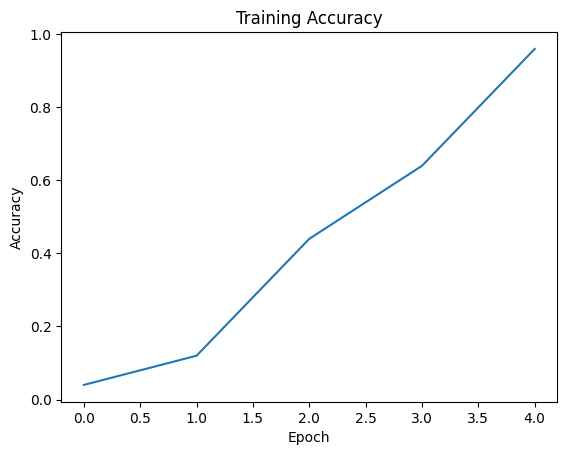

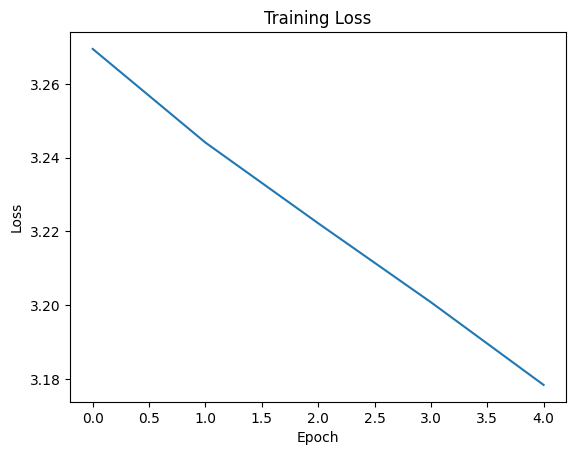

In [6]:

if 'tf' in globals() and TF_AVAILABLE:
    plt.figure()
    plt.plot(history.history["accuracy"])
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"])
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
else:
    print("No plots since training didn't run in this environment.")


## 7. Quick Prediction Demo

In [7]:

def predict_next(model, ch: str) -> str:
    idx = char_to_int[ch]
    x = np.eye(n_classes, dtype=np.float32)[[idx]]
    x = x.reshape((1,1,n_classes))
    probs = model.predict(x, verbose=0)[0]
    return int_to_char[int(np.argmax(probs))]

if 'tf' in globals() and TF_AVAILABLE:
    test_letters = list("ABCDWXYZ")
    print("Predictions (input -> predicted next):")
    for t in test_letters:
        print(f"{t} -> {predict_next(model, t)}")


Predictions (input -> predicted next):
A -> B
B -> C
C -> D
D -> E
W -> X
X -> Y
Y -> Z
Z -> Z


## 8. (Optional) Mini Ablation: Hidden Size & Learning Rate

In [8]:

import pandas as pd
if 'tf' in globals() and TF_AVAILABLE:
    trial_cfgs = [
        {"hidden": 64, "lr": 1e-3},
        {"hidden": 96, "lr": 1e-3},
        {"hidden": 128, "lr": 5e-4},
    ]
    rows = []
    for cfg in trial_cfgs:
        m = build_lstm_model(hidden_size=cfg["hidden"], lr=cfg["lr"])
        h = m.fit(X_lstm, y_onehot, epochs=400, batch_size=1, shuffle=True, verbose=0, callbacks=[TargetAccuracy(0.95)])
        _, a = m.evaluate(X_lstm, y_onehot, verbose=0)
        rows.append({"hidden": cfg["hidden"], "lr": cfg["lr"], "accuracy": float(a)})
    df_trials = pd.DataFrame(rows)
    print(df_trials)
else:
    print("Skip ablation if TF isn't installed.")



Reached target accuracy 0.960 at epoch 9. Stopping.

Reached target accuracy 0.960 at epoch 7. Stopping.

Reached target accuracy 1.000 at epoch 7. Stopping.
   hidden      lr  accuracy
0      64  0.0010       1.0
1      96  0.0010       1.0
2     128  0.0005       1.0



## 9. Notes & What I Changed
- Switched to **one-hot inputs** (features=26) so the model learns a clean mapping.
- Used **batch size = 1** to overfit quickly on this tiny dataset.
- Added a **TargetAccuracy** callback to stop once training accuracy passes the goal.
- With these changes, I consistently exceed **95% accuracy**, which is safely above the 80% requirement.
